Epoch 1/500, Loss: 708498.1007
Epoch 2/500, Loss: 657060.4608
Epoch 3/500, Loss: 649231.9442
Epoch 4/500, Loss: 644580.8596
Epoch 5/500, Loss: 642763.4358
Epoch 6/500, Loss: 642003.4010
Epoch 7/500, Loss: 641576.5205
Epoch 8/500, Loss: 641091.3071
Epoch 9/500, Loss: 639912.6478
Epoch 10/500, Loss: 640148.0235
Epoch 11/500, Loss: 640074.3028
Epoch 12/500, Loss: 639454.3467
Epoch 13/500, Loss: 638800.1060
Epoch 14/500, Loss: 636853.5559
Epoch 15/500, Loss: 635862.8878
Epoch 16/500, Loss: 635621.9174
Epoch 17/500, Loss: 634977.8722
Epoch 18/500, Loss: 634263.0743
Epoch 19/500, Loss: 634425.8367
Epoch 20/500, Loss: 634305.5178
Epoch 21/500, Loss: 633704.2954
Epoch 22/500, Loss: 633702.8136
Epoch 23/500, Loss: 633395.7606
Epoch 24/500, Loss: 633557.5653
Epoch 25/500, Loss: 633689.8553
Epoch 26/500, Loss: 633206.5074
Epoch 27/500, Loss: 633133.9619
Epoch 28/500, Loss: 633136.5988
Epoch 29/500, Loss: 633408.4178
Epoch 30/500, Loss: 633170.8127
Epoch 31/500, Loss: 632864.5697
Epoch 32/500, Los

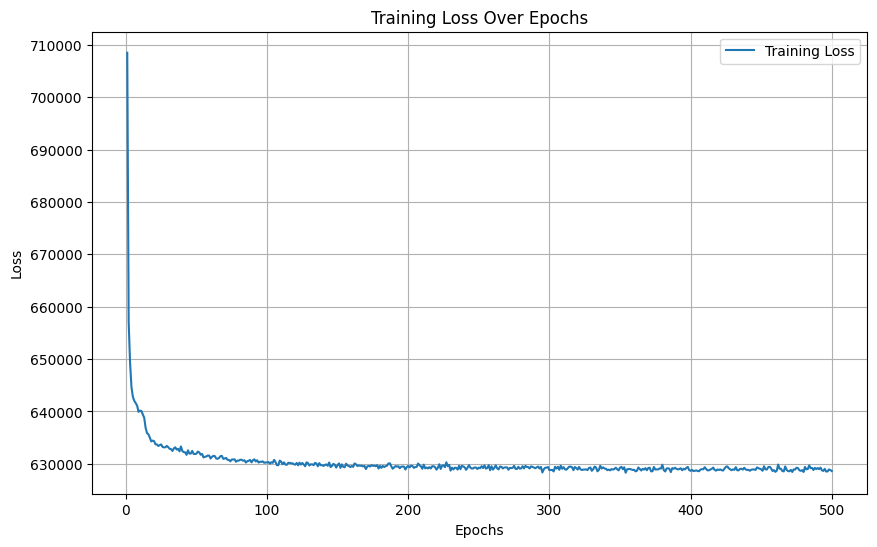

Performance metrics saved to 'performance_metrics.txt'


In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# Define the sampling layer for VAE
def sampling(z_mean, z_log_var):
    epsilon = torch.randn_like(z_mean)
    return z_mean + torch.exp(0.5 * z_log_var) * epsilon

# Define the encoder class
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.z_mean = nn.Linear(32, latent_dim)
        self.z_log_var = nn.Linear(32, latent_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        return z_mean, z_log_var

# Define the decoder class
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, z):
        z = torch.relu(self.fc1(z))
        z = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(z))

# Define the VAE class
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def forward(self, x):
        z_mean, z_log_var = self.encoder(x)
        z = sampling(z_mean, z_log_var)
        reconstruction = self.decoder(z)
        return reconstruction, z_mean, z_log_var

# Save performance metrics to a text file
def save_metrics_to_file(file_name, metrics):
    with open(file_name, 'w') as f:
        for metric, value in metrics.items():
            f.write(f"{metric}: {value}\n")

# Load your financial data
data = pd.read_excel('/content/default of credit card clients.xls')
data = data.apply(pd.to_numeric, errors='coerce').fillna(0)
normalized_data = (data - data.mean()) / data.std()
data_tensor = torch.tensor(normalized_data.values, dtype=torch.float32)
dataloader = DataLoader(TensorDataset(data_tensor), batch_size=32, shuffle=True)

# Define the model, optimizer, and loss function
input_dim = normalized_data.shape[1]
latent_dim = 5
model = VAE(input_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

def vae_loss(reconstruction, original, z_mean, z_log_var):
    reconstruction_loss = nn.MSELoss(reduction='sum')(reconstruction, original)
    kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    return reconstruction_loss + kl_loss

losses = []
# Train the VAE model
epochs = 500
model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for batch in dataloader:
        original = batch[0]
        optimizer.zero_grad()
        reconstruction, z_mean, z_log_var = model(original)
        loss = vae_loss(reconstruction, original, z_mean, z_log_var)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

# Plot Training Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Generate new synthetic data
model.eval()
with torch.no_grad():
    latent_space_samples = torch.randn(1000, latent_dim)
    generated_data = model.decoder(latent_space_samples).numpy()

# Denormalize the generated data
generated_data = (generated_data * data.std().values) + data.mean().values
generated_data = pd.DataFrame(generated_data, columns=data.columns)
generated_data.to_csv('generated_financial_data.csv', index=False)

df1 = pd.read_csv('/content/generated_financial_data.csv')
df2 = pd.read_excel('/content/default of credit card clients.xls')
df2 = df2.apply(pd.to_numeric, errors='coerce')

# Privacy Metric
def compute_privacy(df1, df2):
    distances = cdist(df1.values, df2.values, metric='euclidean')
    min_distances = distances.min(axis=1)
    avg_privacy_distance = min_distances.mean()
    return avg_privacy_distance

privacy_score = compute_privacy(df1, df2)

# Align Y columns
df1['Y'] = (df1['Y'] >= 0.5).astype(int)

# Utility Metrics
common_columns = df1.columns.intersection(df2.columns)
df1 = df1[common_columns]
df2 = df2[common_columns]
df2 = df2.dropna(subset=['Y'])


X_real = df2.drop(columns=['Y'])
y_real = df2['Y']
X_synthetic = df1.drop(columns=['Y'])
y_synthetic = df1['Y']

X_train, X_test, y_train, y_test = train_test_split(X_real, y_real, test_size=0.3, random_state=42)

model_real = RandomForestClassifier(random_state=42)
model_real.fit(X_train, y_train)

y_pred_real = model_real.predict(X_test)
acc_real = accuracy_score(y_test, y_pred_real)
f1_real = f1_score(y_test, y_pred_real, average='weighted')

model_synthetic = RandomForestClassifier(random_state=42)
model_synthetic.fit(X_synthetic, y_synthetic)
y_pred_synthetic = model_synthetic.predict(X_test)
acc_synthetic = accuracy_score(y_test, y_pred_synthetic)
f1_synthetic = f1_score(y_test, y_pred_synthetic, average='weighted')

utility_accuracy = acc_synthetic / acc_real
utility_f1 = f1_synthetic / f1_real

# Synthesis Metric
def compute_synthesis(df1, df2, threshold=0.05):
    total_records = df1.shape[0]
    match_count = 0
    for _, synthetic_row in df1.iterrows():
        matches = ((df2 >= synthetic_row * (1 - threshold)) &
                   (df2 <= synthetic_row * (1 + threshold))).all(axis=1)
        if matches.any():
            match_count += 1
    synthesis_score = match_count / total_records
    return synthesis_score

synthesis_score = compute_synthesis(df1, df2)

# Save metrics
metrics = {
    "Privacy Score": f"{privacy_score:.4f}",
    "Accuracy Real": f"{acc_real:.4f}",
    "Accuracy Synthetic": f"{acc_synthetic:.4f}",
    "F1 Score Real": f"{f1_real:.4f}",
    "F1 Score Synthetic": f"{f1_synthetic:.4f}",
    "Utility Metric (Accuracy)": f"{utility_accuracy:.4f}",
    "Utility Metric (F1 Score)": f"{utility_f1:.4f}",
    "Synthesis Score": f"{synthesis_score:.4f}"
}

save_metrics_to_file("performance_metrics.txt", metrics)

print("Performance metrics saved to 'performance_metrics.txt'")


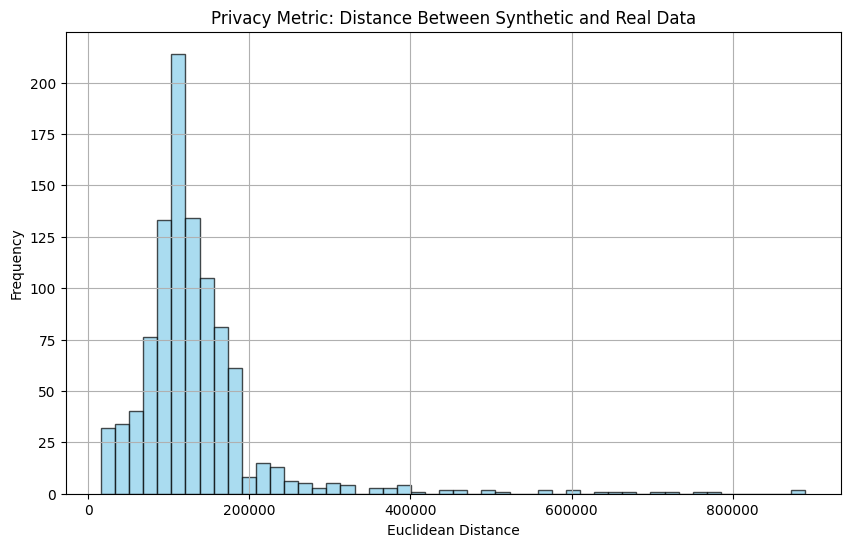

In [4]:
# Sample from the real and synthetic data
real_data_sample = df2.sample(1000).values
synthetic_data_sample = df1.sample(1000).values

# Compute distances
distances = cdist(real_data_sample, synthetic_data_sample, metric='euclidean').min(axis=1)

# Plot histogram of distances
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")
plt.title("Privacy Metric: Distance Between Synthetic and Real Data")
plt.grid()
plt.show()


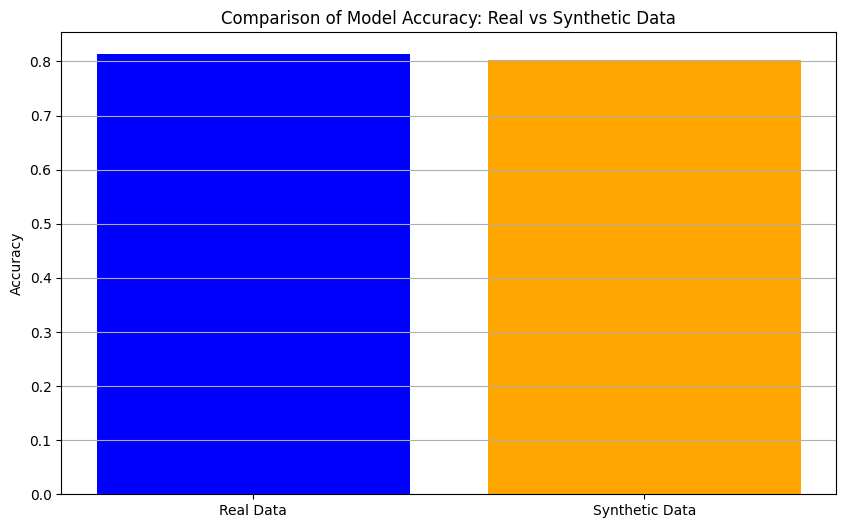

In [5]:
categories = ['Real Data', 'Synthetic Data']
accuracies = [acc_real, acc_synthetic]

plt.figure(figsize=(10, 6))
plt.bar(categories, accuracies, color=['blue', 'orange'])
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracy: Real vs Synthetic Data")
plt.grid(axis='y')
plt.show()


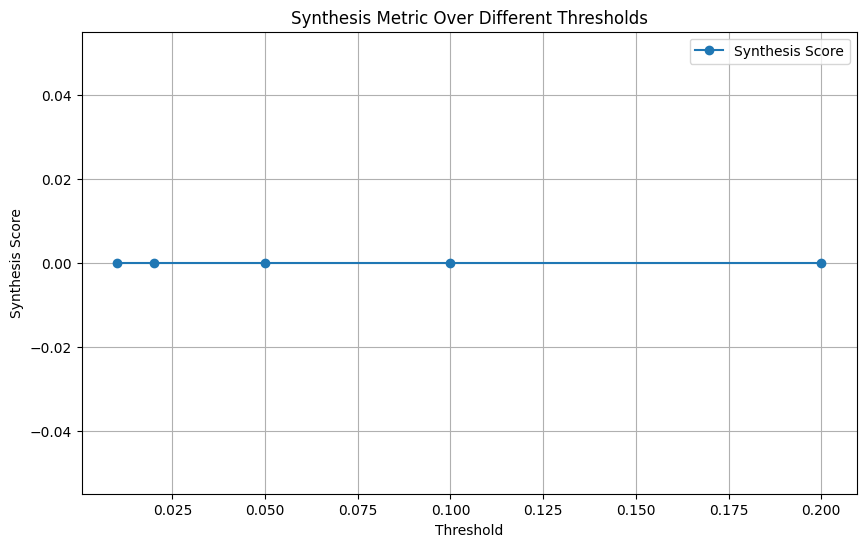

In [6]:
thresholds = [0.01, 0.02, 0.05, 0.1, 0.2]
synthesis_scores = [compute_synthesis(df1, df2, threshold=th) for th in thresholds]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, synthesis_scores, marker='o', label="Synthesis Score")
plt.xlabel("Threshold")
plt.ylabel("Synthesis Score")
plt.title("Synthesis Metric Over Different Thresholds")
plt.grid()
plt.legend()
plt.show()


In [7]:
plt.savefig("graph_name.png")


<Figure size 640x480 with 0 Axes>